In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split
from pycaret.classification import ClassificationExperiment
from pycaret.classification import *
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
#  Read The Dataset And Join It
train_data = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [4]:
train_data.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [5]:
train_data.drop(columns=['id','severe_toxic','obscene','threat','insult','identity_hate'],inplace=True)

In [6]:
train_data = train_data.rename(columns={'comment_text':'text','toxic':'target'})

In [7]:
train_data.head()

,text,target
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   target  159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [9]:
train_data['no_tokens'] = train_data['text'].str.split().map(lambda token: len(token)) 
train_data.sample(10)

,text,target,no_tokens
51081,"""\n\n RE: I Think This Should Be Deleted \nTo ...",0,82
129437,Emtjets Charter Marketplace offers direct acce...,0,24
122514,"That is irrelevant! You're involved, and as an...",0,52
151305,"""\n\nThere is a great deal of ineteresting dis...",0,37
71917,First there's the comparative context – the Se...,0,75
62083,"""\nSaffron Drake (born 26 August 2001) is a gi...",0,31
70187,Does anyone know which of these represents the...,0,18
79524,"""\n This statement http://en.wikipedia.org/w/i...",0,65
24812,obviously Russia is the most important partner...,0,124
121222,"Every source I have, including original German...",0,34


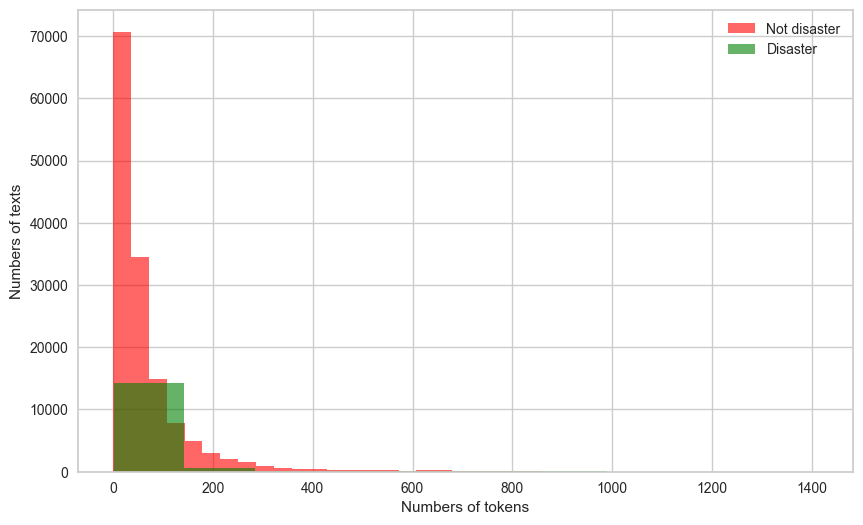

In [10]:
plt.figure(figsize=(10, 6)) 

train_data[train_data['target'] == 0]['no_tokens'].plot(kind='hist', 
                                                color='red', 
                                                label='Not disaster', 
                                                alpha=0.6)

train_data[train_data['target'] == 1]['no_tokens'].plot(kind='hist', 
                                                color='green', 
                                                label='Disaster', 
                                                alpha=0.6)

plt.legend(loc='upper right')
plt.xlabel("Numbers of tokens")
plt.ylabel("Numbers of texts")
plt.show()

In [11]:
train_data.isnull().sum()

text         0
target       0
no_tokens    0
dtype: int64

In [12]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [13]:
def preprocessing_data(texts):
    cleaned_texts = []

    for sent in texts:
        filtered_tokens = [
            lemmatizer.lemmatize(stemmer.stem(re.sub(r'\W', '', token)))
            for token in word_tokenize(re.sub(r'http[s]?://[^\s]+', '', sent).lower())
            if (not token.isnumeric()) and (len(token) > 2)
        ]
        text = " ".join(filtered_tokens)
        cleaned_texts.append(text)

    return cleaned_texts


In [14]:
import sys
sys.setrecursionlimit(10**6)

In [15]:
train_data['clean_text'] = preprocessing_data(train_data['text'].values)
train_data.head() 

,text,target,no_tokens,clean_text
0,Explanation\nWhy the edits made under my usern...,0,43,explan whi the edit made under usernam hardcor...
1,D'aww! He matches this background colour I'm s...,0,17,daww match thi background colour seemingli stu...
2,"Hey man, I'm really not trying to edit war. It...",0,42,hey man realli not tri edit war just that thi ...
3,"""\nMore\nI can't make any real suggestions on ...",0,113,more nt make ani real suggest improv wonder th...
4,"You, sir, are my hero. Any chance you remember...",0,13,you sir are hero ani chanc you rememb what pag...


In [16]:
train_data['text'].iloc[4187]

'"\nEmpowered by amnesty and reward\nThere is a brand new arbcom opened up against Coffee, a precursor of the ""disruption and drama"" and ""utter contempt"" that editors will now have moving forward. Mr. MacDonald cannot have it both ways: he cannot show ""utter contempt"" for ""community consensus"", intentionally creating ""drama and disruption"" then two days later attempt to create ""community consensus"". \n\nAs I wrote in the arbcom:\n""Arbcom sent a powerful, empowering message to editors like Coffee by giving them amnesty: our community rules don\'t matter, and administrators will be forgiven and rewarded for blatantly breaking our community rules""\n\nAs I learned in the KWW RFA, if editors say a blatant falsehood enough times, it becomes truth. Already people are stating that no rules were broken in the RFC BLP, when no one could argue that rules were broken, and I argue they  were broken with ""utter contempt"".\n\nExcuse me but I have an administrator to desysop. You will 

In [17]:
train_data['clean_text'].iloc[4187]

'empow amnesti and reward there brand new arbcom open against coffe precursor the disrupt and drama and utter contempt that editor will now have move forward mr macdonald can not have both way can not show utter contempt for commun consensu intent creat drama and disrupt then two day later attempt creat commun consensu wrote the arbcom arbcom sent power empow messag editor like coffe give them amnesti our commun rule nt matter and administr will forgiven and reward for blatantli break our commun rule learn the kww rfa editor say blatant falsehood enough time becom truth alreadi peopl are state that rule were broken the rfc blp when one could argu that rule were broken and argu they were broken with utter contempt excus but have administr desysop you will happi note that focu scott will minim the next few day focu coffe rich edit histori look forward your comment support coffe the arbcom frank andersson revis restor olymp medallist for sake'

In [18]:
train_data['text'].iloc[4975]

'If you would click on the photo you would know that it was taken January 10th.  There is a strong chance that he was under the influence of marijuana as he seemed kind of out it, which would explain the expression on his face.'

In [19]:
train_data['clean_text'].iloc[4975]

'you would click the photo you would know that wa taken januari 10th there strong chanc that wa under the influenc marijuana seem kind out which would explain the express hi face'

In [20]:
train_data['target'].value_counts()

0    144277
1     15294
Name: target, dtype: int64

In [21]:
train_data['target'].value_counts(normalize=True)

0    0.904156
1    0.095844
Name: target, dtype: float64

In [22]:
df2 = train_data

not_disaster_data = train_data[train_data['target'] == 0]
disaster_data = train_data[train_data['target'] == 1]
disaster_data = resample(disaster_data, replace=True, n_samples=len(not_disaster_data))

df2 = pd.concat([not_disaster_data, disaster_data], axis=0)

balanced_train_data = shuffle(df2)

print("Number of rows after upsampling: \nNot Disaster Data:", len(balanced_train_data[balanced_train_data["target"] == 0]), 
      "\nDisaster Data:", len(balanced_train_data[balanced_train_data["target"] == 1]))

Number of rows after upsampling: 
Not Disaster Data: 144277 
Disaster Data: 144277


In [23]:
balanced_train_data.head(3)

,text,target,no_tokens,clean_text
112992,Go and fist yourself you arrogant prick,1,7,and fist yourself you arrog prick
53181,P ==\n\n E \n\n N \n\n I \n\n S \n\n==,1,7,
22337,Fuck you\n\nDon't tell me how to behave. I hav...,1,19,fuck you nt tell how behav have more power her...


In [54]:
balanced_train_data.isna().sum()

text          0
target        0
no_tokens     0
clean_text    0
dtype: int64

In [24]:
X_train, X_val, y_train, y_val = train_test_split(balanced_train_data['clean_text'], balanced_train_data['target'], test_size=0.2, random_state=7)

In [25]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(230843,)
(57711,)
(230843,)
(57711,)


In [26]:
balanced_train_data.reset_index(drop=True, inplace=True)

In [27]:
exp = ClassificationExperiment()
exp.setup(data=balanced_train_data, target='target')


,Description,Value
0,Session id,2585
1,Target,target
2,Target type,Binary
3,Original data shape,"(288554, 4)"
4,Transformed data shape,"(288554, 4)"
5,Transformed train set shape,"(201987, 4)"
6,Transformed test set shape,"(86567, 4)"
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


In [55]:
best = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9987,0.9987,0.9974,1.0000,0.9987,0.9974,0.9974,0.7520
ridge,Ridge Classifier,0.9987,0.0000,0.9974,1.0000,0.9987,0.9974,0.9974,0.7600
rf,Random Forest Classifier,0.9987,0.9986,0.9974,1.0000,0.9987,0.9974,0.9974,1.8770
ada,Ada Boost Classifier,0.9987,0.9987,0.9974,1.0000,0.9987,0.9974,0.9974,0.7540
gbc,Gradient Boosting Classifier,0.9987,0.9987,0.9974,1.0000,0.9987,0.9974,0.9974,1.9270
lda,Linear Discriminant Analysis,0.9987,0.9990,0.9974,1.0000,0.9987,0.9974,0.9974,0.8450
et,Extra Trees Classifier,0.9987,0.9986,0.9974,1.0000,0.9987,0.9974,0.9974,1.0720
lightgbm,Light Gradient Boosting Machine,0.9987,0.9987,0.9974,1.0000,0.9987,0.9974,0.9974,0.7770
lr,Logistic Regression,0.9985,0.9989,0.9975,0.9996,0.9985,0.9971,0.9971,1.1820
knn,K Neighbors Classifier,0.9940,0.9985,0.9970,0.9911,0.9940,0.9880,0.9881,1.2180


In [29]:
best

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=2585, splitter='best')

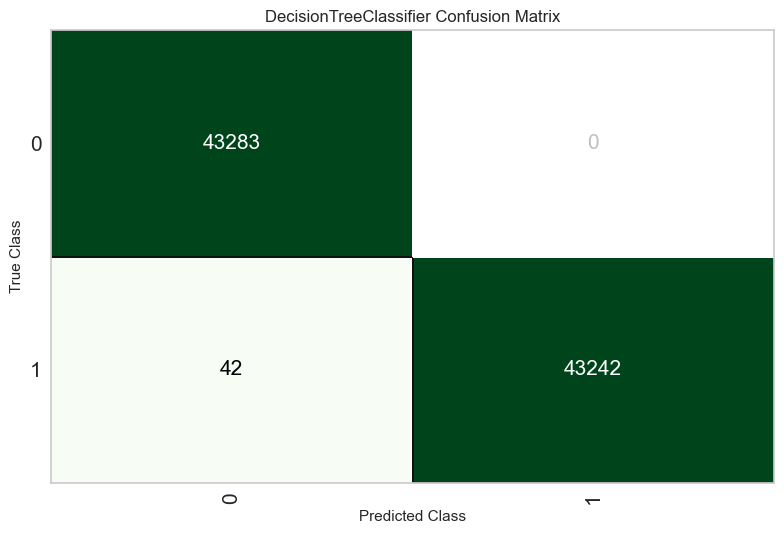

In [30]:
# plot confusion matrix
exp.plot_model(best, plot = 'confusion_matrix')

In [31]:
# predict on test set
holdout_pred = exp.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.9995,0.9995,0.9990,1.0000,0.9995,0.9990,0.9990


# Machine Learning Model

In [56]:
decision_tree_classifier = DecisionTreeClassifier(
    ccp_alpha=0.0,
    class_weight=None,
    criterion='gini',
    max_depth=None,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    random_state=2585,
    splitter='best'
)


In [57]:
# Define a TF-IDF Vectorizer
tfidf = TfidfVectorizer()
# Create a pipeline with TF-IDF Vectorizer and DTClassifier
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classifier', decision_tree_classifier)
])

In [58]:
# Train the model using textual data and labels
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        random_state=2585, splitter='best'))],
         verbose=False)

In [59]:
predictions = pipeline.predict(X_val)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, predictions)
precision = precision_score(y_val, predictions)
recall = recall_score(y_val, predictions)
f1 = f1_score(y_val, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9651
Precision: 0.9349
Recall: 1.0000
F1 Score: 0.9663


In [8]:
input_text = "i love you"

input_prediction = pipeline.predict([input_text])

# Display the prediction
print(f"Predicted class: ", "Negative" if input_prediction[0] == 1 else "Positive")


Predicted class:  Positive


In [10]:
input_text = "i hate you"

input_prediction = pipeline.predict([input_text])

# Display the prediction
print(f"Predicted class: ", "Negative" if input_prediction[0] == 1 else "Positive")


Predicted class:  Negative


In [3]:
import joblib
# joblib.dump(pipeline, 'DTC.joblib')

In [4]:
loaded_model = joblib.load('DTC.joblib')
